In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import PIL

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Pre Process

In [4]:
data_dir = "archive\Garbage classification\Garbage classification"
img_height = 224
img_width = 224  


<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\jiray\AppData\Local\Temp\ipykernel_30376\2365749546.py:1: SyntaxWarning: invalid escape sequence '\G'
  data_dir = "archive\Garbage classification\Garbage classification"


In [5]:
class_count = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_count[class_name] = num_files
    print(f"{class_name} {num_files}")

max_class = max(class_count.values())
print(class_count)
print(f"Max class = {max_class}")

cardboard 594
glass 594
metal 594
paper 594
plastic 594
{'cardboard': 594, 'glass': 594, 'metal': 594, 'paper': 594, 'plastic': 594}
Max class = 594


Data Augmentation

In [30]:
class ProbabilisticLayer(tf.keras.layers.Layer):
    def __init__(self, layer, probability=0.5, **kwargs):
        super(ProbabilisticLayer, self).__init__(**kwargs)
        self.layer = layer
        self.probability = probability

    def call(self, inputs, training=None):
        # ถ้าไม่ได้อยู่ในโหมด training ให้ข้ามไปเลย
        if not training:
            return inputs
        
        # สุ่มค่าระหว่าง 0-1
        # ถ้าค่าน้อยกว่า probability ที่กำหนด ให้รัน Layer ข้างใน
        if tf.random.uniform(()) < self.probability:
            return self.layer(inputs)
        # มิฉะนั้น ให้ส่งข้อมูลเดิมกลับไป
        else:
            return inputs

In [31]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        ProbabilisticLayer(tf.keras.layers.RandomRotation(0.2), probability=0.5),
        ProbabilisticLayer(tf.keras.layers.RandomZoom(0.2), probability=0.5),
        ProbabilisticLayer(tf.keras.layers.RandomBrightness(factor=0.2), probability=0.3),
        ProbabilisticLayer(tf.keras.layers.RandomContrast(factor=0.2), probability=0.3)
    ]
)

In [32]:
import glob

for class_name, current_count in class_count.items():
    if current_count < max_class:
        num_to_generate = max_class - current_count
        
        class_path = os.path.join(data_dir, class_name)
        # print(class_path)
        search_pattern = os.path.join(class_path, "*.jpg")
        image_paths = glob.glob(search_pattern)
        # print(image_paths)

        for i in range(num_to_generate):
            random_image_path = np.random.choice(image_paths)
            img = tf.keras.utils.load_img(random_image_path)
            img_array = tf.keras.utils.img_to_array(img)
            # print(img_array.shape)
            img_tensor = tf.expand_dims(img_array, 0) #แปลงเป็น batch โดย batch_size = 1
            # print(img_tensor)
            # break
            augmented_tensor = data_augmentation(img_tensor)
            augmented_image = tf.keras.utils.array_to_img(augmented_tensor[0]) #แปลง tensor to img ได้เหมือนกัน


            original_filename = os.path.basename(random_image_path) #เอามาแต่ข้างหลังสุด
            filename_without_ext = os.path.splitext(original_filename)[0]
            new_filename = f"{filename_without_ext}_aug_{i}.jpg"
            full_path_to_save = os.path.join(class_path, new_filename)
            augmented_image.save(full_path_to_save)

c:\Users\jiray\OneDrive\Documents\Linear_project\venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'probabilistic_layer_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\jiray\OneDrive\Documents\Linear_project\venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'probabilistic_layer_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\jiray\OneDrive\Documents\Linear_project\venv\Lib\site-packages\

In [33]:
class_count = {}
for class_name in os.listdir(data_dir):
  class_path = os.path.join(data_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_count[class_name] = num_files
    print(f"{class_name} {num_files}")

max_class = max(class_count.values())
print(class_count)
print(f"Max class = {max_class}")

cardboard 594
glass 594
metal 594
paper 594
plastic 594
{'cardboard': 594, 'glass': 594, 'metal': 594, 'paper': 594, 'plastic': 594}
Max class = 594


In [34]:
# files_to_delete = []

# search_pattern = os.path.join(data_dir, '**', '*_aug_*.jpg')
# files_to_delete = glob.glob(search_pattern, recursive=True)

# print(f"--- พบไฟล์ที่จะลบทั้งหมด {len(files_to_delete)} ไฟล์ ---")
# for file_path in files_to_delete:
#     print(file_path)
# print("---------------------------------------------")


# confirmation = input("คุณต้องการลบไฟล์เหล่านี้ทั้งหมดใช่หรือไม่? (y/n): ")
# for file_path in files_to_delete:
#     os.remove(file_path) # คำสั่งลบไฟล์ของ os
# print(f"ลบไฟล์ทั้งหมด {len(files_to_delete)} ไฟล์เรียบร้อยแล้ว")

In [35]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,                  
  subset="training",                      
  seed=2222,                              
  image_size=(img_height, img_width),   
  batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",                
  seed=2222,
  image_size=(img_height, img_width), 
  batch_size=32
)

Found 2970 files belonging to 5 classes.
Using 2376 files for training.
Found 2970 files belonging to 5 classes.
Using 594 files for validation.


In [36]:
class_names = train_ds.class_names
print(class_names)
print(f"class numbers {len(class_names)}")

['cardboard', 'glass', 'metal', 'paper', 'plastic']
class numbers 5


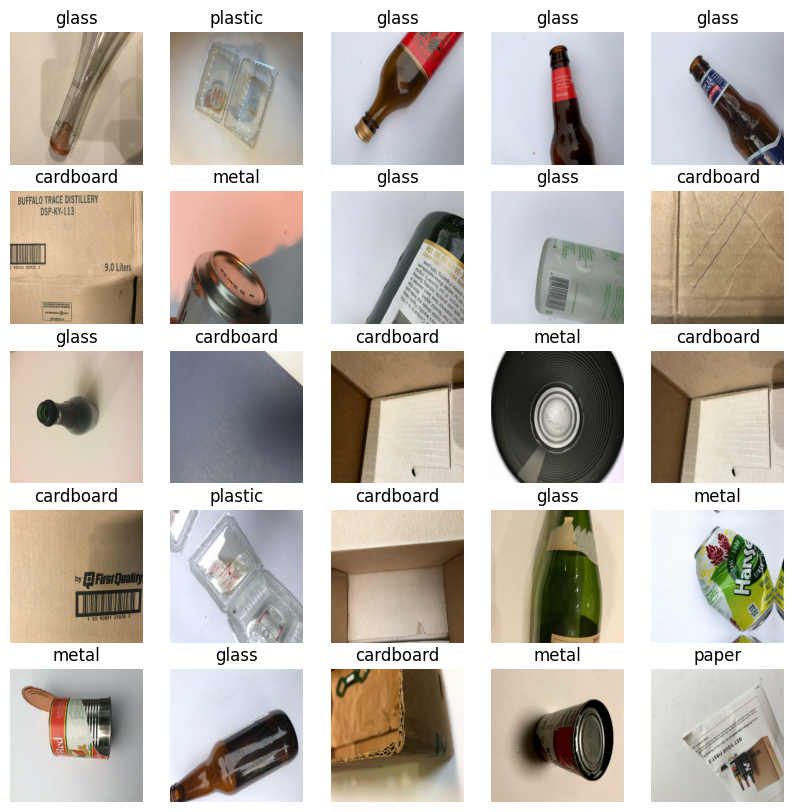

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(32, 224, 224, 3)
(32,)


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255.0, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

c:\Users\jiray\OneDrive\Documents\Linear_project\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,013 (50.49 MB)

 Trainable params: 13,235,013 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras',                  
                                               monitor='val_loss', mode='min',
                                               save_best_only=True,
                                               verbose=1,)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) 

In [43]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  callbacks=[callback, early_stopping]
)

Epoch 1/100


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.2175 - loss: 1.6103
Epoch 1: val_loss improved from None to 1.58554, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 700ms/step - accuracy: 0.2311 - loss: 1.6057 - val_accuracy: 0.3519 - val_loss: 1.5855
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.2863 - loss: 1.5825
Epoch 2: val_loss improved from 1.58554 to 1.53242, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 698ms/step - accuracy: 0.3009 - loss: 1.5714 - val_accuracy: 0.4714 - val_loss: 1.5324
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.3826 - loss: 1.5143
Epoch 3: val_loss improved from 1.53242 to 1.40527, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 744ms/step - accuracy: 0.3944 - loss: 1.4949 - val_accuracy: 0.5387 - val_loss: 1.4053
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.4349 - loss: 1.4171
Epoch 4: val_loss improved from 1.40527 to 1.30312, saving

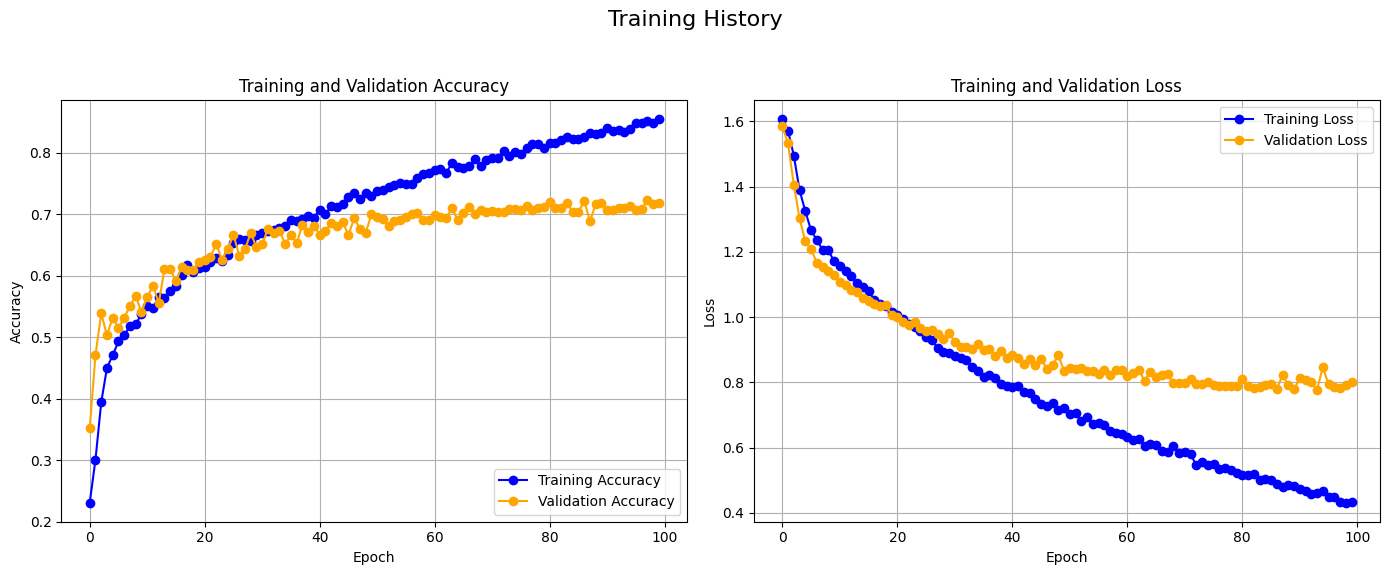

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# สร้างช่วงของแกน X (จำนวน epochs)
epochs_range = range(len(acc))
# --- สร้างกราฟ ---
plt.figure(figsize=(14, 6)) # กำหนดขนาดของพื้นที่วาดทั้งหมด

# กราฟที่ 1: Training and Validation Accuracy
plt.subplot(1, 2, 1) # สร้าง subplot ที่ 1 (จากทั้งหมด 1 แถว 2 คอลัมน์)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True) # เพิ่มเส้นกริด

# กราฟที่ 2: Training and Validation Loss
plt.subplot(1, 2, 2) # สร้าง subplot ที่ 2
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True) # เพิ่มเส้นกริด

# แสดงกราฟทั้งหมด
plt.suptitle('Training History', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # ปรับ layout ให้สวยงาม
plt.show()

In [45]:

loss, accuracy = model.evaluate(val_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.7104 - loss: 0.7773
Test Loss: 0.7773
Test Accuracy: 71.04%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


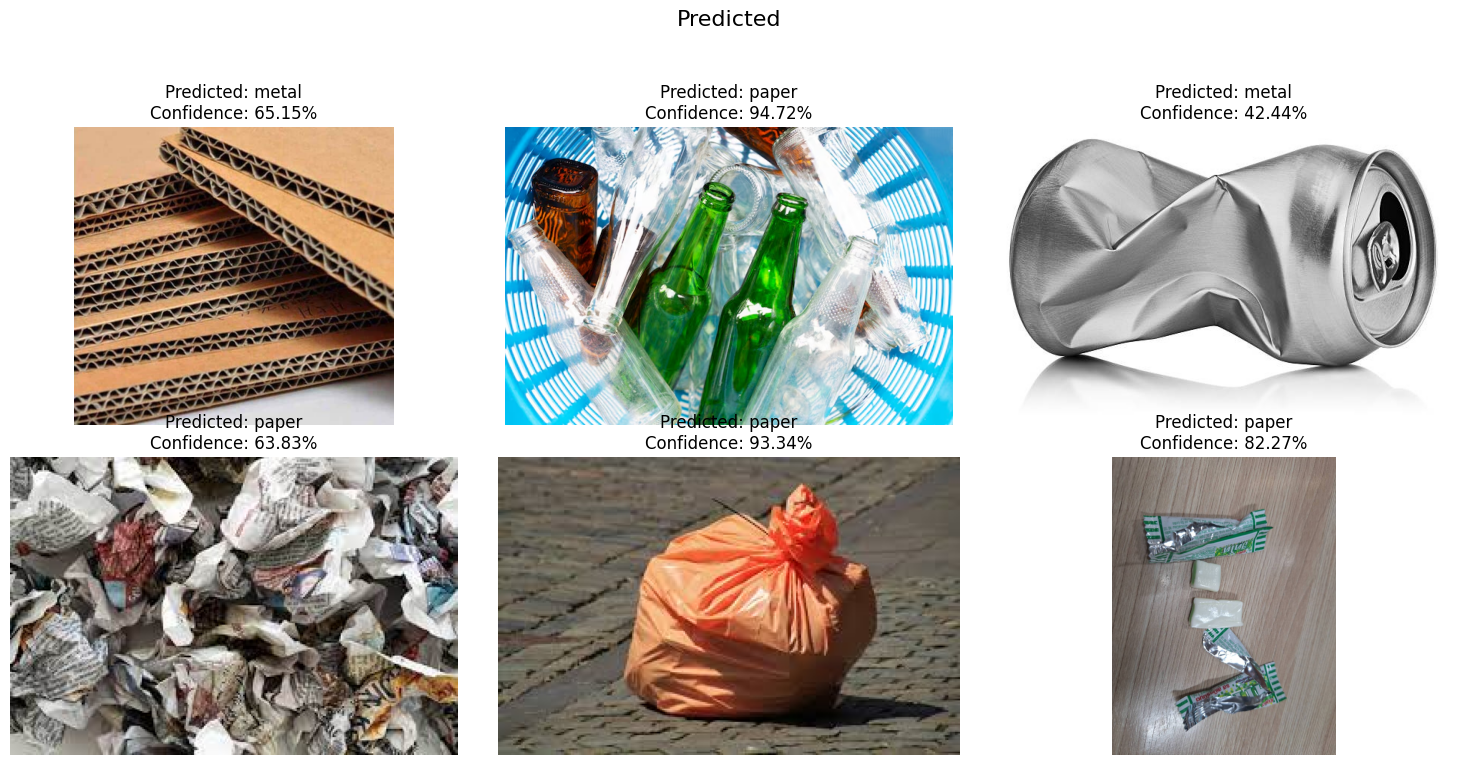

In [46]:
best_model = tf.keras.models.load_model('best_model.keras')

test_folder = 'test_image/'
image_paths = [os.path.join(test_folder, fname) for fname in os.listdir(test_folder) if fname.endswith('.jpg')]

batch_holder = []
for path in image_paths:
    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    batch_holder.append(img_array)

image_batch = np.array(batch_holder)

predictions = best_model.predict(image_batch)
scores = tf.nn.softmax(predictions)

plt.figure(figsize=(15, 8)) 
plt.suptitle("Predicted", fontsize=16)

for i in range(len(image_paths)):
    ax = plt.subplot(2, 3, i + 1)
    img_display = tf.keras.utils.load_img(image_paths[i])
    
    predicted_class = class_names[np.argmax(scores[i])]
    confidence = 100 * np.max(scores[i])

    plt.imshow(img_display)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [47]:
import cv2
import numpy as np

# --- ⭐️ การตั้งค่าโมเดลของคุณ ⭐️ ---
WEIGHTS_PATH = 'garbage_classifier.weights'
CONFIG_PATH = 'yolov4-tiny-custom.cfg'
NAMES_PATH = 'obj.names'

# --- การตั้งค่าอื่นๆ ---
CONF_THRESHOLD = 0.5  # ลองปรับค่านี้ตามความเหมาะสมของโมเดลคุณ
NMS_THRESHOLD = 0.4
VIDEO_PATH = 0  # ใช้เว็บแคม

# --- โหลดโมเดล Custom ---
print("กำลังโหลดโมเดล Custom...")
net = cv2.dnn.readNet(WEIGHTS_PATH, CONFIG_PATH)
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA) # เปิดใช้ GPU ถ้ามี
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# --- โหลดชื่อ Class ทั้งหมด ---
with open(NAMES_PATH, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
try:
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
except TypeError:
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

print("โหลดโมเดลสำเร็จ!")
print(f"โมเดลของคุณรู้จัก Class ต่อไปนี้: {classes}")

# --- ส่วนที่เหลือของโค้ดจะเหมือนเดิม ---
cap = cv2.VideoCapture(VIDEO_PATH)

tracker = None
tracking_box = None
tracking_label = ""

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    height, width, channels = frame.shape

    if tracker is None:
        # --- โหมดตรวจจับ (Detection Mode) ---
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (180, 180), (0, 0, 0), True, crop=False) # ⭐️ ข้อควรระวัง: ขนาด Input (416, 416) ต้องตรงกับในไฟล์ .cfg
        net.setInput(blob)
        outs = net.forward(output_layers)

        class_ids = []
        confidences = []
        boxes = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > CONF_THRESHOLD:
                    center_x, center_y = int(detection[0] * width), int(detection[1] * height)
                    w, h = int(detection[2] * width), int(detection[3] * height)
                    x, y = int(center_x - w / 2), int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRESHOLD, NMS_THRESHOLD)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                text = f"{label}: {confidences[i]:.2f}"
                cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.putText(frame, "Detection Mode - Press 's' to track", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    else:
        # --- โหมดติดตาม (Tracking Mode) ---
        success, box = tracker.update(frame)
        if success:
            (x, y, w, h) = [int(v) for v in box]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            text = f"Tracking: {tracking_label}"
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        else:
            cv2.putText(frame, "Tracking failed!", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
            tracker = None
            
        cv2.putText(frame, "Tracking Mode - Press 'd' to re-detect", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    cv2.imshow("My Custom Model - Real-time Tracking", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    if key == ord('s') and tracker is None and 'boxes' in locals() and len(boxes) > 0:
        if len(indexes) > 0:
            i = indexes.flatten()[0] # เลือก Track วัตถุแรกที่เจอ
            tracking_box = tuple(boxes[i])
            tracking_label = str(classes[class_ids[i]])
            tracker = cv2.TrackerCSRT_create()
            tracker.init(frame, tracking_box)
            print(f"Start tracking: {tracking_label}")
    elif key == ord('d'):
        tracker = None
        print("Switched to Detection Mode")

cap.release()
cv2.destroyAllWindows()

กำลังโหลดโมเดล Custom...


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\darknet\darknet_importer.cpp:210: error: (-212:Parsing error) Failed to open NetParameter file: yolov4-tiny-custom.cfg in function 'cv::dnn::dnn4_v20250619::readNetFromDarknet'
